In [ ]:
# 설치 실패시, Internet On/Off 확인
!pip install easydict

In [ ]:
import os, random, pickle
from os.path import join
from glob import glob
from time import time

from tqdm.notebook import tqdm

from easydict import EasyDict as edict

import numpy as np
from PIL import Image

from sklearn.svm import OneClassSVM

from sklearn.decomposition import PCA, KernelPCA

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display


## 산업 환경 상의  영상 기반 비정상 케이스 검출

이상 상황 검출이란, 데이터에서 예상과는 다른 패턴을 보이는 개체 또는 자료를 찾는 것을 말합니다. 
다양한 분야에서 사용되어지며, 각 분야 별 사용 예시는 아래와 같습니다.

-  사이버 보안. e.g. 비정상적인 트래픽 패턴을 감지
-  의학 분야. e.g. MRI 이미지로부터의 악성 종양 검출
-  금융 분야. e.g. 신용카드 거래 내역의 이상 검출을 통한 분실 및 도난 감지
-  행동 패턴 분야. e.g. CCTV를 통한 이상 패턴 감지를 통한 사고 방지
-  산업 분야. e.g.  생산된 제품의 품질 검사   <br>

 이상 상황은 위의 예시와 같이 드물게 나타나며 특정하기 힘든 형태로 나타나는 경우가 많습니다. 이런 특성상 특정 분포로 정의하기 힘들어, 정상 데이터와 다른 분포를 가진 데이터를 이상 상황이라고 칭합니다. 혹은 다른 관점으로는 기존 데이터 분포와 다른 새로운 분포를 가진 데이터를 찾는다고 하여 novelty detection라고도 불리기도 합니다. 이처럼 특정 분포를 정의하기 힘든 특성상  이상상황에 대한 데이터 셋을 구축하기 매우 힘듭니다. 이러한 사유로 대부분의 이상상황 검출들은 이상상황에 대한 데이터와 라벨이 필요한 지도학습보다는 라벨이 불필요한 비지도 학습 혹은 준 비지도 학습을 기반으로 문제를 해결합니다. 

 이번 텀프로젝트에서는 다양한 분야 중 산업 환경 상의 이상 상황 검출 문제를 다룰 예정입니다. 해당 문제는 MVTec AD 데이터 셋을 이용하여 비지도 학습 기반의 이상 상황 검출을 구현합니다. 비지도 학습 기반 검출기는 수업에서 다룬 차원 축소 알고리즘 PCA(Principal Compoent Analysis)와  분류기인 SVM(Support-Vector Machine)류의 모델 One-class SVM을 다뤄볼 예정 입니다.

## Dataloader

### MVTEC AD
이번 텀프로젝트에서는 산업 분야 중 제조업 분야에서의 비지도 학습 기반 이상 검출 데이터 셋 MVTEC AD([homepage](https://www.mvtec.com/company/research/datasets/mvtec-ad), [pdf](https://www.mvtec.com/fileadmin/Redaktion/mvtec.com/company/research/datasets/mvtec_ad.pdf))를 이용하여 이상 상황 검출을 풀어보고자합니다.  해당 데이터 셋은 아래와 같이 총 15가지의 클래스를 가진 영상을 제공하며,  각 클래스에 해당하는 제조업에서 발생할 수 있는 이상 상황(품질 불량)을 인위적으로 생성하였으며, 영상에서의 제조품이 명확하도록 설계된 조명과 배경과 영상 가운데에 위치하도록 촬영되었습니다. 각 클래스의 예제 영상들은 Overview-Description Fig 1에서 확인 할 수 있습니다.
데이터 셋 구성은 [MVTecAD_colab](https://colab.research.google.com/drive/1pdgvoPs3KDLq6pV9oLxkXDh6waEp76HT?usp=sharing)에서도 확인 할 수 있습니다.
<br>

#### 데이터 셋 구성

데이터 셋의 영상 갯수는 아래와 같습니다.

train : 3629장 -> 정상 상황에 해당하는 영상만 존재.<br>
test : 467(good) + 1258(fault case) -> 정상 상황에서의 영상(good)과 이상 상황에서의 영상(failt case)로 구성. <br>
all : 5354장 <br>

데이터 파일의 구조는 아래와 같습니다.

{ClassName} Original dataset과 동일 <br>
|--val.csv : col1 : ID. test 영상 파일명, col2 : label. good:1, fault:-1 <br>
|--train <br>
|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|---good <br>
|__test <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|--- good&fault case <br>

# 새 섹션

In [ ]:
class MVTec_AD():
    def __init__(self, DB_PATH, OUT_PATH, size=(86,86), flatten=True):
        '''
        DB_PATH : str. e.g. {workspace}/dataset
        size : (int, int). default (86, 86)
        flatten : bool. [num_of_img_per_class, h*w]/[num_of_img_per_class, h, w]
        '''
        self.DB_PATH = DB_PATH
        self.out_path = OUT_PATH
        self.size, self.flatten = size, flatten

        self.class_names = ['bottle', 'cable', 'capsule', 'carpet', 'grid',
                            'hazelnut', 'leather', 'metal_nut', 'pill', 'screw',
                            'tile', 'transistor', 'wood', 'zipper']


    def read_mvtec(self, cls="bottle", mode='train'):
        '''
        input
          cls : str. class name.
          mode : str. {train, test, val}
        output
          db_dict : dict. 
                  if val in mode
                   {'imgs':[num_of_img_per_class, h*w or h, w], 'labels':gt, 'class_name':class_name}
                  else
                   {'imgs':[num_of_img_per_class, h*w or h, w], 'class_name':class_name}
        '''

        # Load cache data.
        CACHE_PATH = self.out_path + '/cache'
        cache_ = join(CACHE_PATH, mode)
        if self.flatten: cache_+= 't_'
        cache_+=f'{str(self.size)}_{cls}.pkl'

        # if exist cache data return data
        if os.path.isfile(cache_):
            with open(cache_, 'rb') as f:
                data = pickle.load(f)
            return data
        # else load imgs and cache data
        else:
            if os.path.isdir(CACHE_PATH)!=True:
                os.mkdir(CACHE_PATH)

            # load imgs
            data = edict()  
            if mode == 'val':
                csv = pd.read_csv(join(self.DB_PATH, cls, 'val.csv'))
                data.imgs = [f'{self.DB_PATH}/{cls}/test/{csv.iloc[id, 0]:03d}.png' for id in csv.index]
                data.labels = [csv.iloc[id, 1] for id in csv.index]
            else:
                data.imgs = sorted(glob(join(self.DB_PATH, cls, mode, '*.png')))

            data.class_name = cls

            data = self.read_img(data)

            # cache data
            with open(cache_, "wb") as f:
                pickle.dump(data, f)

            return data
        
    def read_img(self, db_dict):
        im_path = db_dict.imgs
        len_imgs = len(im_path)

        db_dict.imgs = np.array([np.array(Image.open(im).convert("L").resize(self.size)) for im in im_path])
        if self.flatten:
            db_dict.imgs = db_dict.imgs.reshape(len_imgs,-1)
      
        return db_dict

In [ ]:
import matplotlib.pyplot as plt

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

In [ ]:
# load val, train data
DB_PATH = "../input/2021-ml-tp04/MVTecAD"
OUT_PATH = "./"

size = (86, 86)
cls = 'bottle'
dataset = MVTec_AD(DB_PATH, OUT_PATH, flatten=True, size=size)

val = dataset.read_mvtec(cls=cls, mode='val')
train = dataset.read_mvtec(cls=cls, mode='train')
test = dataset.read_mvtec(cls=cls, mode='test')

# 해당 데이터 셋은 비지도 학습을 위한 데이터 셋이기 때문에,
# train data는 정상 케이스의 영상들로만 구성되어 있습니다.
# 베이스 코드에서는 train의 key 정보와 같이 train의 라벨을 주어주지 않습니다.
# 데이터 구성에 대한 내용은 https://colab.research.google.com/drive/1pdgvoPs3KDLq6pV9oLxkXDh6waEp76HT?usp=sharing에 있습니다. 해당 부분도 보시기 바랍니다.
# 위의 URL 주소는 Dataset 설명란의 MVTecAD_colab과 동일한 주소입니다.
# ++ 만약에 train의 라벨이 필요하신 분들은 각 클래스의 train 폴더의 data.csv를 사용하시기 바랍니다.
print(train.keys())
print(val.keys())
print(test.keys())

## 이상 상황 검출(Anomaly Detection)

 이번 텀프로젝트에서는 이상 상황 검출을 위한 평가 방법 중 하나의 클래스에서 이상치를 찾는 것을 목적으로한 One-classification 방법을 이용하여 이상 상황을 평가하도록 합니다. One-classification을 간단하게 설명드리자면 각 클래스 별 학습과 평가를 별도로 진행합니다. 즉, MVTecAD의 14가지 클래스 별 추론과 평가를 진행합니다.  사용되는 평가 메트릭은 ROC를 사용합니다.

이번 텀프에서는 영상 기반의 이상 상황 검출을 적용되며 크게 두가지로 분류되어집니다.

- Reconstruction based anomaly detection
  - 정상 영상으로부터 정상적 특성을 잘표현하는 feature를 추출하는 encoder와
  - 추출된 feature를 원본 영상과 유사하게 복원하는 Decoder로 구성
  - 정상적인 데이터로 학습된 encoder-decoder로 이상 영상을 복원 시, 정상 영상과 유사하도록 복원 영상을 생성될 것이라고 가정을 함.
  - 입력 영상 I과 encoder-decoder로 복원된 영상 I'의 차이를 정상/이상에 대한 분류 점수로 사용.
  - 이상 영상과 복원 영상(이상)의 차이는 크고, 정상 영상과 복원 영상(정상)의 차이는 작음
- Embedding feature based anomaly detection
  - 정상 영상의 정상적인 특성을 학습한 feature extrator를 이용하여  정상/이상 영상의 feature를 추출
  - 정상 feature의 분포 경계를 잘 배우도록 모델을 학습
  - 정상 feature의 분포 경계에 벗어나는 경우 이상치로 검출

텀프로젝트에서는 PCA를 활용하여 위의 두 가지 방법을 적용하는 것이 목표입니다. 

#### Reconstruction based anomaly detection

이번 텀프로젝트에서의 Reconstruction based anomaly detection은 PCA로 이뤄진 encoder와 decoder를 이용합니다. 
파이프라인은 아래와 같습니다.

1. PCA를 이용하여 정상 영상으로 구성된 train data의 주성분을 추출하여 train data를  feature f로 n_component 크기가 되도록 차원 축소(feature 추출)
2. 정상/이상 영상이 포함된 test data에 1에서 적용된 PCA로 featrue f_test 추출
3. featrue f_test를 복원
4. 원본 영상과 복원 영상의 차를 구하여 socre를 추출



In [ ]:
# -------------------------------------
# [Empty Module #1] Reconstruction based anomaly detection
# -------------------------------------
# 
# ------------------------------------------------------------
# 구현 가이드라인 
# ------------------------------------------------------------
# [1] train.imgs와 val.imgs =  정규화.
# [2] PCA 초기화 및 train imgs를 학습
# Baseline : PCA(n_components=n_components), random_state=777
# [3] val imgs를 transform.
# [4] [3]로 얻은 val_pca를 inverse_transform을 통해 복원. scaler의 
# inverse_transform을 진행 후, (num_data_imgs, img_width, img_height)로 reshape.
# [5] Reconstruction_error = Original imgs - Reconstruction imgs
# Original imgs : reshape (num_data_imgs, img_width, img_height)를 해야합니다.
 # ------------------------------------------------------------
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
n_components = 0.8
    
sc = StandardScaler()
train.imgs = sc.fit_transform(train.imgs)
val.imgs = sc.transform(val.imgs)

pca = PCA(n_components=n_components, random_state=777)
pca.fit(train.imgs)
val_pca = pca.transform(val.imgs)

Reconstruction_imgs = sc.inverse_transform(val.imgs)
Reconstruction_imgs = Reconstruction_imgs.reshape(len(Reconstruction_imgs),86,86)

ori = val.imgs.reshape(len(val.imgs), 86, 86)

Reconstruction_error = ori - Reconstruction_imgs
cls_score = Reconstruction_error.sum(axis=1).sum(axis=1)
cls_score = sc.fit_transform(cls_score.reshape(-1, 1))

y_pred = cls_score

th = 0.5
y_pred[cls_score < th] = -1
y_pred[cls_score > th] = 1
y_pred = y_pred.reshape(-1)

#____________________
# metric. ROC_AUC
gt_list = np.asarray(val.labels)
fpr, tpr, _ = roc_curve(gt_list, cls_score)
img_roc_auc = roc_auc_score(gt_list, cls_score)

plt.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (cls, img_roc_auc))
plt.title(f'{cls} ROCAUC: {img_roc_auc:.3f}')

print(f'{cls} ROCAUC: {img_roc_auc:.3f}')


#____________________
# Visualize
# original
target_names = {-1:'abnormal', 1:'normal'}
orginal_title = [f'{cls}_{target_names[label]}' for label in gt_list]
plot_gallery(ori, orginal_title, size[0], size[1])


prediction_titles = [title(y_pred, gt_list, target_names, i)
                     for i in range(y_pred.shape[0])]
# Reconstruction img                     
plot_gallery(Reconstruction_imgs, prediction_titles, size[0], size[1])
# Reconstruction error img                     
plot_gallery(Reconstruction_error, prediction_titles, size[0], size[1])


plt.show()
#____________________

#### Embedding feature based anomaly detection

이번 텀프로젝트에서의 embedding feature based anomaly detection은 randomized PCA와 one-class SVM을 이용합니다.
파이프라인은 아래와 같습니다.

1. Randomized PCA를 이용하여 정상 영상의 feature f를 추출
2.  one-class SVM을 이용하여 f의 support vector를 학습합니다.
  
    2a. 이부분에서 cross-validation 통해서 다른 모델 (rf, gradient boosting decision tree, 아님 logistic regression) 같은걸로 비교해서 간략한 performance cross-validation 결과 비교 
3. 1에서 사용된 randomized PCA 이상/정상 영상의 feature f_ts를 추출니다.
4. one-class SVM로 f_ts가 정상 분포 경계에 포함 여부로 정상/이상을 분류합니다.


Metric : ROC_AUC [위키피디아](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

In [ ]:
DB_PATH = "../input/2021-ml-tp04/MVTecAD"

OUT_PATH = './'
FIG_PATH = join(OUT_PATH, "fig")
if os.path.isdir(FIG_PATH)!=True:
    os.mkdir(FIG_PATH)

# -------------------------------------
# [Empty Module #2]
# -------------------------------------
# ------------------------------------------------------------
# 구현 가이드라인 
# ------------------------------------------------------------
# Empty Module
# [0] classification module과 pca 모델 초기화
#  사용된 PCA. e.g. PCA, RandomizePCA, KernelPCA...
# Baseline : sklearn.svm.OneClassSVM, kernel="rbf", gamma=0.001, nu=0.01
# Baseline : PCA(n_components=n_components), random_state=777
# RandomizePCA ~(svd_solver='randomized') 사용시, whiten=True로 사용.
# [1] train.imgs와 val.imgs 정규화.
# [2] PCA 초기화와 정규화된 train.imgs를 학습 후, 정규화된 train.imgs, val imgs를 transform.
# [3] OneClassSVM을 이용하여 차원 축소된 train 학습 후 val data 추론. 
# hint. OneClassSVM.predict, OneClassSVM.score_samples 사용.
# [4] test.imgs에 [1]~[3]과 동일한 과정을 적용. 단, 추론 시 score에 대해서만 계산


n_components=180

size = (86, 86)

dataset = MVTec_AD(DB_PATH, OUT_PATH, flatten=True, size=size)

y_preds = []
y_test = []

roc_auc = dict()
total_roc_auc = []
pbar = tqdm(dataset.class_names)

plt.figure(figsize=[10, 10])
# print(f'\n=====clf:{clf_name}, DA:{dr_name}=====')
# total_roc_auc = []

sample_submit = pd.read_csv('../input/2021-ml-tp04/sample_submit.csv', index_col=0)
i=0
for cls in pbar:
    try:
        
        train = dataset.read_mvtec(cls=cls, mode='train')
    except:
        import pdb;pdb.set_trace()
    val = dataset.read_mvtec(cls=cls, mode='val')
    test = dataset.read_mvtec(cls=cls, mode='test')
    
    # [0]
    clf = OneClassSVM(kernel="rbf", gamma=0.001, nu=0.01)
    pca = PCA(svd_solver='randomized', whiten=True, n_components=n_components, random_state=774)
    
    # [1]
    sc = StandardScaler()

    train.imgs = sc.fit_transform(train.imgs)
    val.imgs = sc.transform(val.imgs)
    test.imgs = sc.transform(test.imgs)
    
    # [2]
    train.imgs = pca.fit_transform(train.imgs)
    val.imgs = pca.transform(val.imgs)
    test.imgs = pca.transform(test.imgs)
    
    ## val
    # [3]
    # 변수명
    clf.fit(train.imgs)
    y_pred = clf.predict(val.imgs)
    cls_score_val = clf.score_samples(val.imgs)

    ## test
    #[4]
    # 변수명
    # cls_score : clf.score_samples
    cls_score = clf.score_samples(test.imgs)
    
    #####################
    # eval~valid data
    y_preds.append(y_pred)
    gt_list = np.array(val.labels)
    fpr, tpr, _ = roc_curve(gt_list, cls_score_val)
    img_roc_auc = roc_auc_score(gt_list, cls_score_val)
    total_roc_auc.append(img_roc_auc)
    plt.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (cls, img_roc_auc))


    #신혜민 edited-------- 
    #####
    #이부분이 cross-validation 부분인가요
    #####


    #=======================================================================
    # Submit & predict test data
    sample_submit['score'][i:i+cls_score.shape[0]] = sc.fit_transform(cls_score.reshape(-1,1)).reshape(-1)
    i = i+cls_score.shape[0]
    #=======================================================================

print('Average ROCAUC: %.3f' % np.mean(total_roc_auc))
clf_name = type(clf).__name__
pca_name = type(pca).__name__
plt.title(f'{clf_name}_{pca_name}_{n_components}\nAverage image ROCAUC: {np.mean(total_roc_auc):.3f}' )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Result Figure
plt.savefig(f'{FIG_PATH}/{clf_name}_{pca_name}_{n_components}.jpg')

# Submit CSV
sample_submit.to_csv(f'./{clf_name}_{pca_name}_{n_components}.csv')

##2 one-class SVM을 이용하여 f의 support vector를 학습합니다
*   sample code  



In [ ]:
SVM_params = {'C':[0.001, 0.1, 10, 100], 'kernel':['rbf' ,'linear', 'poly', 'sigmoid'], 'gamma':['auto']}
LR_params = {'C':[0.001, 0.1, 1, 10, 100], 'solver':['liblinear']}
LDA_params = {'n_components':[None, 1,2,3], 'solver':['svd'], 'shrinkage':[None]}
RF_params = {'n_estimators':[10,50,100], 'random_state':[42]}
GBC_params = {'n_estimators':[10, 50, 100], 'random_state':[42]}

models_opt = []

models_opt.append(('LR', LogisticRegression(), LR_params))
models_opt.append(('LDA', LinearDiscriminantAnalysis(), LDA_params))
models_opt.append(('RFC', RandomForestClassifier(), RF_params))
models_opt.append(('SVM', SVC(), SVM_params))
models_opt.append(('GBC', GradientBoostingClassifier(), GBC_params))

results = []
names = []

for name, model, params in models_opt:
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    model_grid = GridSearchCV(model, params, cv=5, iid=True)
    cv_results = cross_val_score(model_grid, X_train_norm, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "Cross Validation Accuracy {} Accarcy: {} SD: {}".format(name, cv_results.mean(), cv_results.std())
    print(msg)

Cross Validation Accuracy LR Accarcy: 0.9083645443196003 SD: 0.020108790603446586
Cross Validation Accuracy LDA Accarcy: 0.9328339575530586 SD: 0.024709767591869027
Cross Validation Accuracy RFC Accarcy: 0.94187265917603 SD: 0.028667236347817576
Cross Validation Accuracy SVM Accarcy: 0.9106117353308363 SD: 0.018204969921156756
Cross Validation Accuracy GBC Accarcy: 0.9374282147315857 SD: 0.02500938023931507


#### As anticipated, Random Forest and Gradient Boosting Decision Tree gave the highest accuracies, although Linear Discrimant came very close. Let us plot the distribution of accuracies of these models for better comparison.

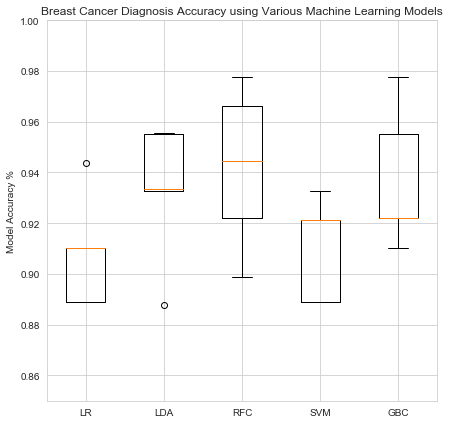

In [ ]:
fig = plt.figure(figsize=(7,7))
plt.boxplot(results, labels = names)
plt.title('Breast Cancer Diagnosis Accuracy using Various Machine Learning Models')
plt.ylabel('Model Accuracy %')
sns.set_style("whitegrid")
plt.ylim(0.85,1)
plt.show()